2023-02-07

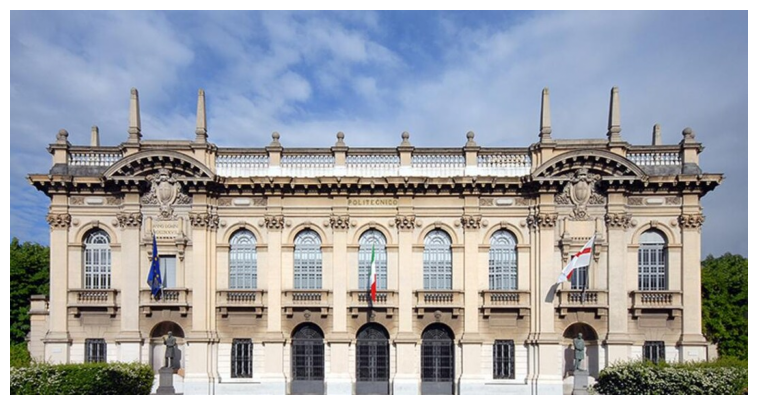

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

image_path = 'polimi_compress.jpg'
img = imread(image_path)
img_RGB = [np.array(img[:,:,i], dtype = np.float64)/255 for i in range(3)]

def plot_image(RGB, ax = None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize = (12,5))
    ax.imshow(np.clip(np.stack(RGB, axis = -1),0,1))
    plt.axis('off')

plot_image(img_RGB)

Now, randomly replace 70% of the pixels with random colors.

In [2]:
damage_fraction = 0.7

np.random.seed(0)
mask_remove = np.random.choice(a=[True, False], size=(img.shape[0],img.shape[1]), \
p=[damage_fraction, 1-damage_fraction])
mask_keep = np.logical_not(mask_remove)

img_damaged_RGB = [img_RGB[i].copy() for i in range(3)]
for i in range(3):
    img_damaged_RGB[i][mask_remove] = np.random.rand(np.sum(mask_remove))

1. Display the damaged image.

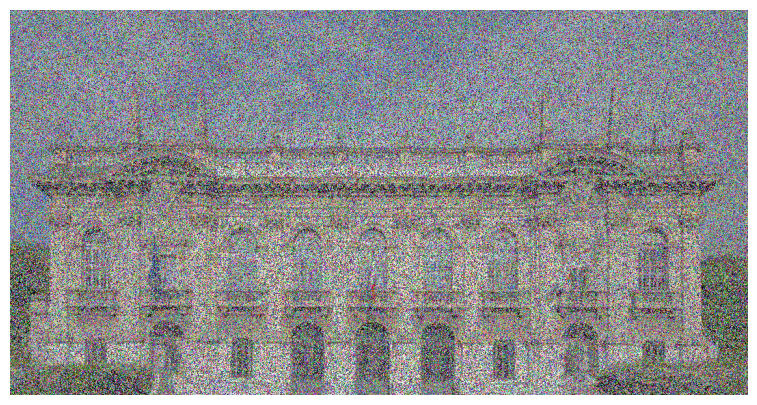

In [3]:
# 1. Display the damaged image.
plot_image(img_damaged_RGB)

Implement the singular value truncation (SVT) algorithm to reconstruct the picture from img damaged RGB.
(Hint: apply the algorithm independently to each channel.)

In [4]:
from scipy.stats import pearsonr

def SVT(img_damaged, img_original, n_max_iter=20, threshold=100.0, increment_tol=1e-6): #note: n_max_iteration should be big (100+) but it take too much time to iterate otherwise
    RMSE_list = list()
    rho_list = list()
    
    A = img_damaged.copy()
    
    for i in range(n_max_iter):
        A_old = A.copy()
        U,s,VT = np.linalg.svd(A, full_matrices = False)
    
        s[s < threshold] = 0
        A = U @ np.diag(s) @ VT
    
        A[mask_keep] = img_original[mask_keep]
        increment = np.linalg.norm(A - A_old)
    
        vals_predicted = A[mask_remove]
        errors = img_original[mask_remove] - vals_predicted
    
        RMSE_list.append(np.sqrt(np.mean(errors**2)))
        rho_list.append(pearsonr(img_original[mask_remove],vals_predicted)[0])
    
        # print('=============== Iteration %d - increment norm %1.3e' % (i+1, increment))
        # print('RMSE: %1.3f' % RMSE_list[-1])
        # print('rho:  %1.3f' % rho_list[-1])
        if increment < increment_tol:
            break
    return A, RMSE_list, rho_list

def SVT_RGB(img_damaged, img_original, threshold=100.0):
    reconstruction = []
    rmse = {}
    rho = {}
    
    r, rmse_list, rho_list = SVT(img_damaged_RGB[0], img_RGB[0], threshold=threshold)
    reconstruction.append(r)
    rmse['r'] = rmse_list
    rho['r'] = rho_list
    
    r, rmse_list, rho_list = SVT(img_damaged_RGB[1], img_RGB[1], threshold=threshold)
    reconstruction.append(r)
    rmse['g'] = rmse_list
    rho['g'] = rho_list

    r, rmse_list, rho_list = SVT(img_damaged_RGB[2], img_RGB[2], threshold=threshold)
    reconstruction.append(r)
    rmse['b'] = rmse_list
    rho['b'] = rho_list

    return reconstruction, rmse, rho


Try to optimize by trial and error the threshold on the singular values. Run the algorithm for 20 iterations
and plot the resulting image against the original and the damaged one.

NameError: name 'math' is not defined

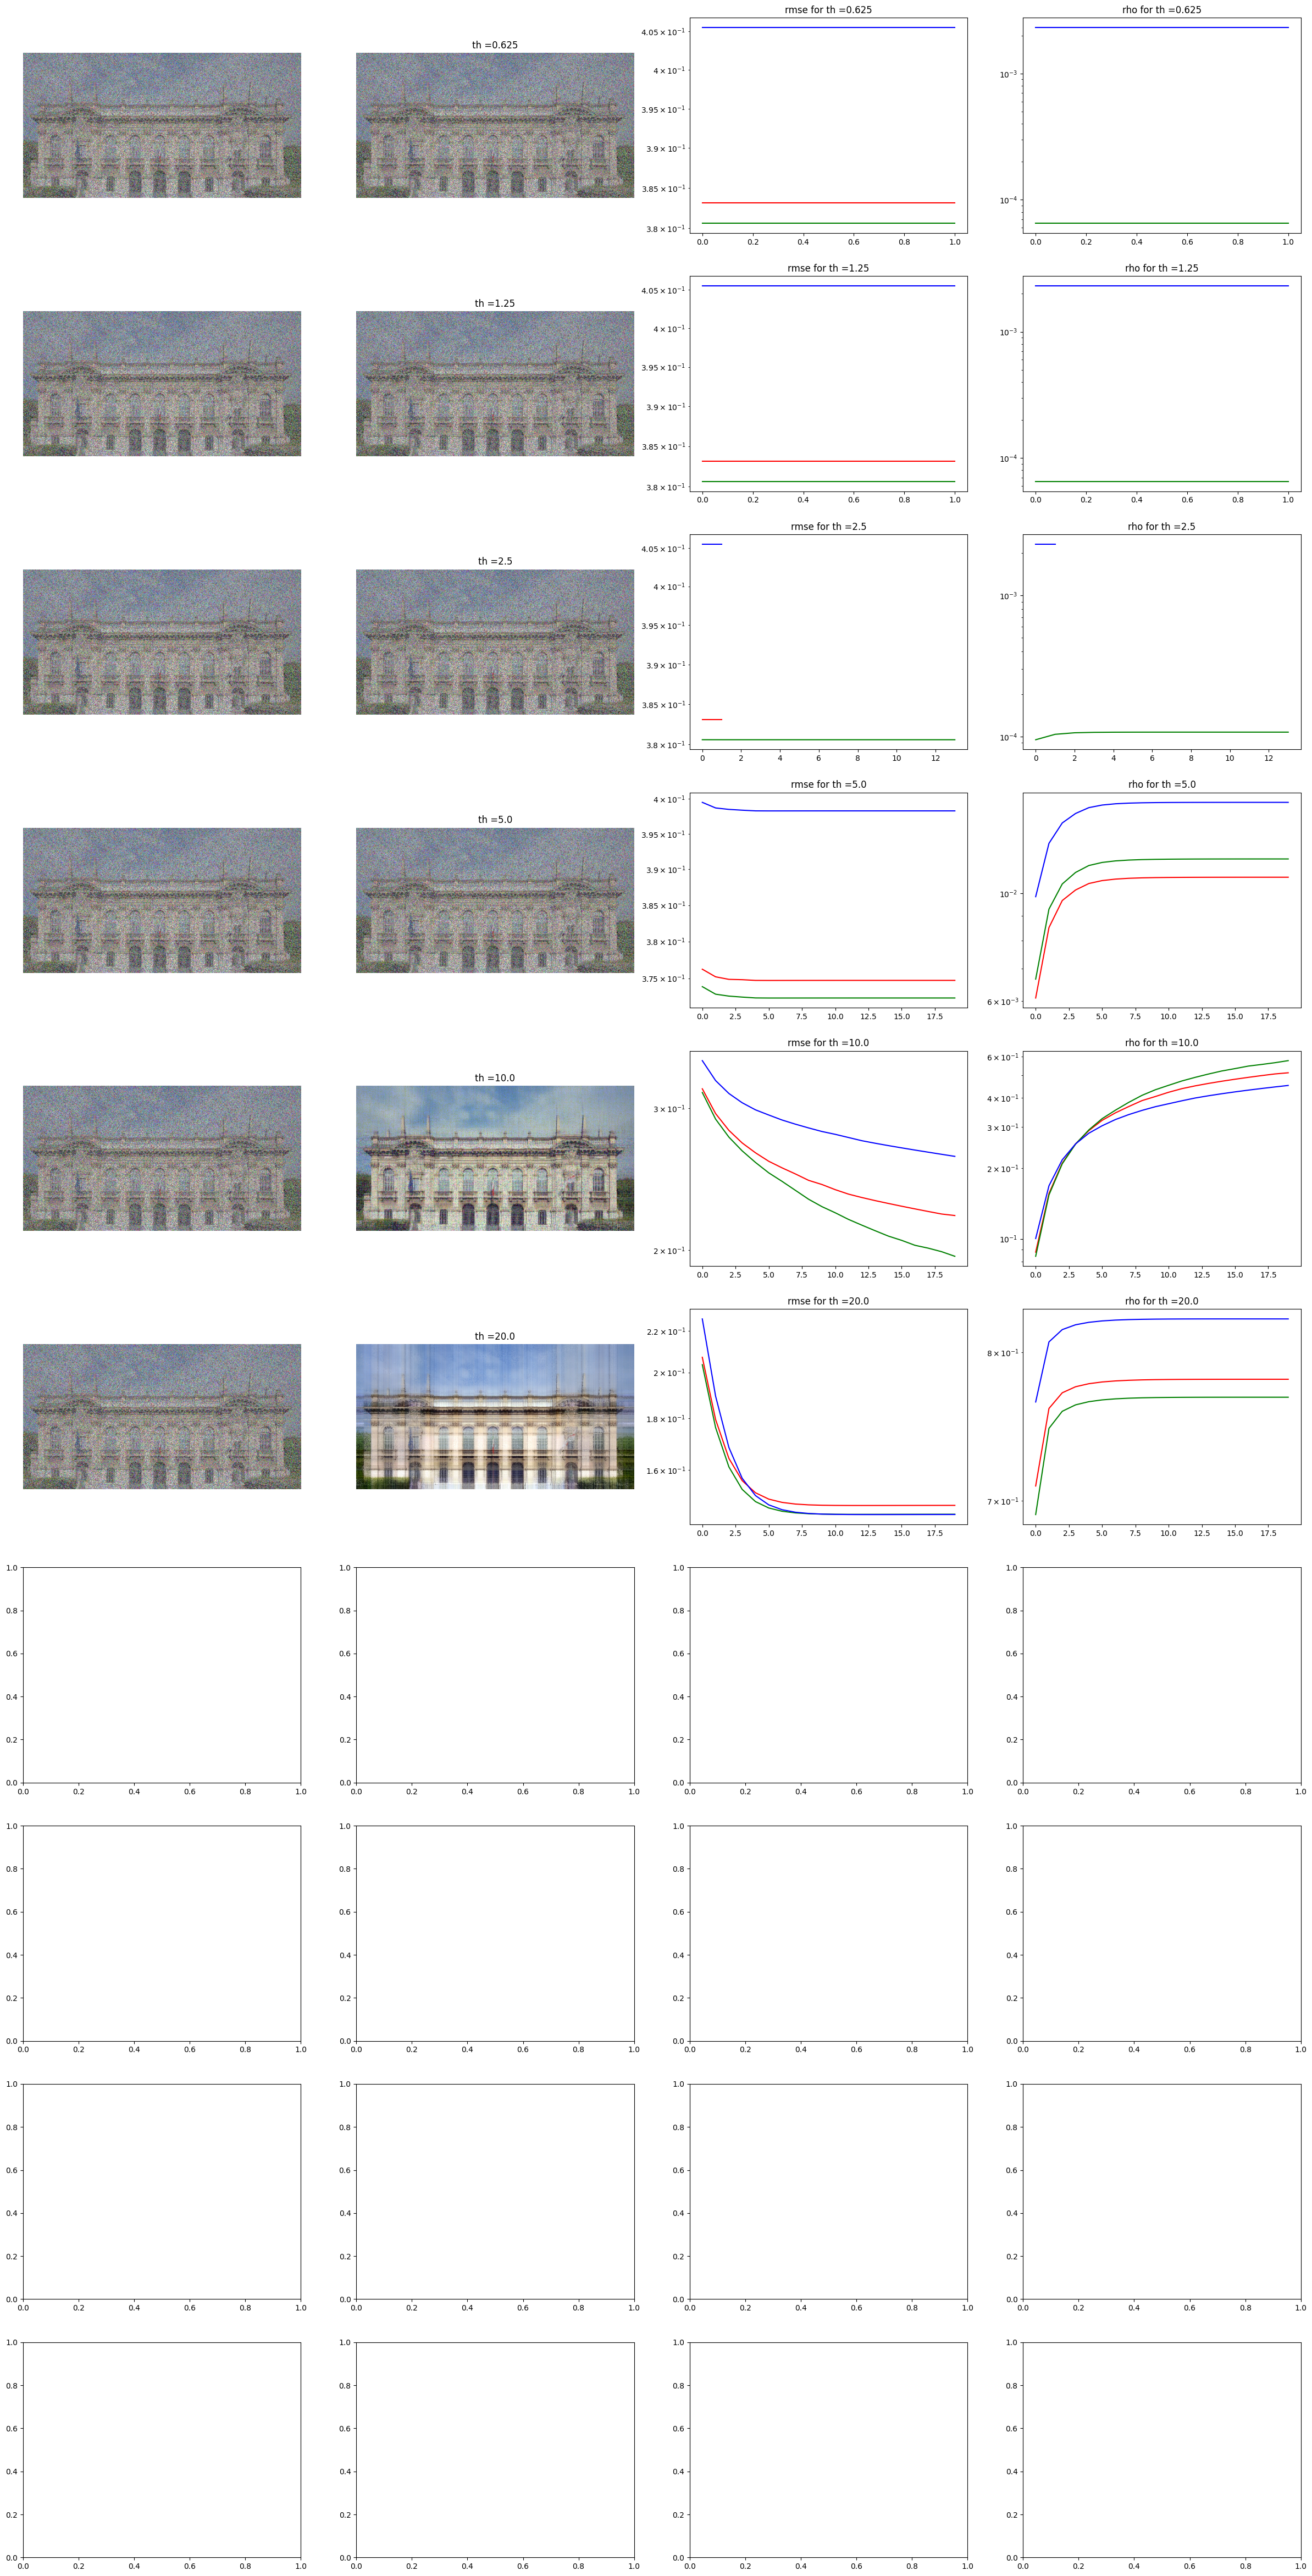

In [6]:
starting_threshold = 0.625
iteration_num = 10
iteration = 0
def plot_pretty(axs, iteration, img_damaged_RGB, r, rmse, rho, th):
    axs[iteration][0].imshow(np.clip(np.stack(img_damaged_RGB, axis = -1),0,1))
    axs[iteration][1].imshow(np.clip(np.stack(r, axis = -1),0,1))
    axs[iteration][1].set_title(f'th ={th}')
    axs[iteration][0].axis('off')
    axs[iteration][1].axis('off')
    
    for el in rmse:
        if len(rmse[el])==1:
            rmse[el] += rmse[el]
    axs[iteration][2].semilogy(rmse['r'], color='red')
    axs[iteration][2].semilogy(rmse['g'], color='green')
    axs[iteration][2].semilogy(rmse['b'], color='blue')
    axs[iteration][2].set_title(f'rmse for th ={th}')
    for el in rho:
        if len(rho[el])==1:
            rho[el] += rho[el]
    axs[iteration][3].semilogy(rho['r'], color='red')
    axs[iteration][3].semilogy(rho['g'], color='green')
    axs[iteration][3].semilogy(rho['b'], color='blue')
    axs[iteration][3].set_title(f'rho for th ={th}')

fig, axs = plt.subplots(nrows=iteration_num, ncols=4, figsize=(30,60))


cur_threshold = starting_threshold
best_k = -1
best_rho = 0

for i in range(0, iteration_num):
    r, rmse, rho = SVT_RGB(img_damaged_RGB, img_RGB, threshold=cur_threshold)
    plot_pretty(axs, i, img_damaged_RGB, r, rmse, rho, cur_threshold)
    if best_k == -1:
        best_k = cur_threshold
        best_rho = cur_threshold
    elif best_rho < (rho['g'][-1] + rho['r'][-1] + rho['b'][-1])/3:
        if not(math.isnan(rho['g'][-1])) and not(math.isnan(rho['r'][-1])) and not(math.isnan(rho['b'][-1])): 
            best_k = cur_threshold
            best_mse = (rho['g'][-1] + rho['r'][-1] + rho['b'][-1])/3
    cur_threshold *= 2

print('\n\n__BEST RHO:', best_rho, 'OBTAINED FOR threshold =', best_k, '__')


Comment on the impact of the threshold on the results

In [ ]:
# Comment on the impact of the threshold on the results
# The threshold on the singular values determines the amount of information that is kept in the reconstruction.
# A lower threshold will keep more information, while a higher threshold will keep less information.
# The threshold is a trade-off between the quality of the reconstruction and the amount of information kept.
# A threshold that is too low will keep too much information and the reconstruction will be similar to the damaged image.
# A threshold that is too high will keep too little information and the reconstruction will be very different from the original image.
# The optimal threshold depends on the specific image and the amount of damage.